<a href="https://colab.research.google.com/github/bhumi223344/Classification-of-Lung-cancer-images-using-machine-learning/blob/main/final_major_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stopping search: maximum iterations reached --> 20
Best parameters found by RandomizedSearchCV for SVC:
{'C': np.float64(7.896910002727692), 'gamma': np.float64(0.696850157946487), 'kernel': 'linear'}
Best parameters found by RandomizedSearchCV for MLP:
{'activation': 'tanh', 'alpha': np.float64(0.0005666566321361543), 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best parameters found by RandomizedSearchCV for KNN:
{'n_neighbors': 9, 'weights': 'distance'}
Accuracy with SVC and optimized parameters: 100.00%
SVC Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00       268

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

Accuracy with MLP and optimized parameters: 100.00%
MLP Classification Report
              precis

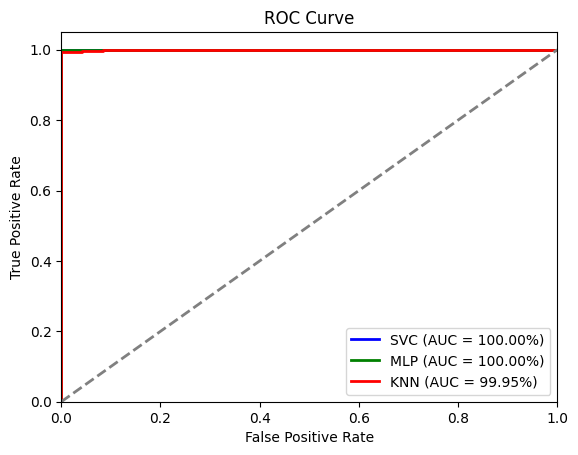

In [4]:
!pip install pyswarm
!pip install scikit-image
!pip install matplotlib
!pip install scikit-learn

from skimage.feature import hog, graycomatrix, local_binary_pattern
from skimage import io, transform, img_as_ubyte
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from pyswarm import pso
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from scipy.ndimage import median_filter
from scipy.stats import uniform, randint

# Function to apply adaptive median filter
def adaptive_median_filter(image, max_size):
    filtered_image = image.copy()
    for size in range(3, max_size + 1, 2):
        median_img = median_filter(image, size=size)
        mask = (image == 0) | (image == 255)
        filtered_image[mask] = median_img[mask]
    return filtered_image

# Function to load and preprocess a single image
def load_image(image_path, label):
    img = io.imread(image_path, as_gray=True)
    if img is not None:
        img = transform.resize(img, (100, 100))
        img = img_as_ubyte(img)

        # Apply adaptive median filtering
        img = adaptive_median_filter(img, max_size=7)

        # Extract GLCM features
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = np.ravel(glcm)

        # Extract LTP features
        ltp = local_binary_pattern(img, P=8, R=1, method='uniform')
        ltp_hist, _ = np.histogram(ltp.ravel(), bins=np.arange(0, 10), range=(0, 9))

        # Extract HOG features
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')

        # Concatenate features
        features = np.hstack((glcm_features, ltp_hist, hog_features))
        return features, label
    return None, None

# Function to load and preprocess images from folders using multiprocessing
def load_images_from_folder(folder):
    images = []
    labels = []
    tasks = []
    with ThreadPoolExecutor() as executor:
        for label, label_folder in enumerate(['benign classes', 'malignant classes']):
            path = os.path.join(folder, label_folder)
            for filename in os.listdir(path):
                img_path = os.path.join(path, filename)
                tasks.append(executor.submit(load_image, img_path, label))
        for task in tasks:
            features, label = task.result()
            if features is not None:
                images.append(features)
                labels.append(label)
    return images, labels

# Load images and labels
data_folder = "/content/drive/MyDrive/lung cancer/dataset"
images, labels = load_images_from_folder(data_folder)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Splitting the dataset into training and testing sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Function to evaluate the feature subset
def evaluate_features(features, X_train, y_train, X_test, y_test):
    selected_features = [bool(int(f)) for f in features]
    if sum(selected_features) == 0:
        return 1.0
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    model = DecisionTreeClassifier()  # Using Decision Tree for faster evaluation
    model.fit(X_train_selected, y_train)

    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    return -accuracy

# Define the bounds for PSO
num_features = X_train.shape[1]
lb = [0] * num_features
ub = [1] * num_features

# Run PSO with optimized parameters
best_features, best_accuracy = pso(evaluate_features, lb, ub, args=(X_train, y_train, X_test, y_test), swarmsize=10, maxiter=20)

# Convert the best feature set from PSO to boolean
selected_features = [bool(int(f)) for f in best_features]

# Train and evaluate the final models with the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Use a smaller subset for hyperparameter tuning
sss_tune = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
for train_index, _ in sss_tune.split(X_train_selected, y_train):
    X_train_tune, y_train_tune = X_train_selected[train_index], y_train[train_index]

# Reduce parameter grid sizes for faster execution
param_dist_svc = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.1, 1),
    'kernel': ['rbf', 'linear']
}

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

param_dist_knn = {
    'n_neighbors': randint(3, 10),
    'weights': ['uniform', 'distance']
}

# Use RandomizedSearchCV for faster hyperparameter tuning
rand_svc = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist_svc, n_iter=10, cv=3, n_jobs=-1, random_state=42)
rand_mlp = RandomizedSearchCV(MLPClassifier(max_iter=500), param_distributions=param_dist_mlp, n_iter=10, cv=3, n_jobs=-1, random_state=42)
rand_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=10, cv=3, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV for each model
rand_svc.fit(X_train_tune, y_train_tune)
rand_mlp.fit(X_train_tune, y_train_tune)
rand_knn.fit(X_train_tune, y_train_tune)

# Best parameters for each model
print("Best parameters found by RandomizedSearchCV for SVC:")
print(rand_svc.best_params_)

print("Best parameters found by RandomizedSearchCV for MLP:")
print(rand_mlp.best_params_)

print("Best parameters found by RandomizedSearchCV for KNN:")
print(rand_knn.best_params_)

# Evaluate the best models found by RandomizedSearchCV
svc_model = rand_svc.best_estimator_
svc_model.fit(X_train_selected, y_train)
svc_predictions = svc_model.predict(X_test_selected)
svc_probs = svc_model.predict_proba(X_test_selected)[:, 1]
svc_accuracy = accuracy_score(y_test, svc_predictions)
print(f"Accuracy with SVC and optimized parameters: {svc_accuracy * 100:.2f}%")
print("SVC Classification Report")
print(classification_report(y_test, svc_predictions))

mlp_model = rand_mlp.best_estimator_
mlp_model.fit(X_train_selected, y_train)
mlp_predictions = mlp_model.predict(X_test_selected)
mlp_probs = mlp_model.predict_proba(X_test_selected)[:, 1]
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print(f"Accuracy with MLP and optimized parameters: {mlp_accuracy * 100:.2f}%")
print("MLP Classification Report")
print(classification_report(y_test, mlp_predictions))

knn_model = rand_knn.best_estimator_
knn_model.fit(X_train_selected, y_train)
knn_predictions = knn_model.predict(X_test_selected)
knn_probs = knn_model.predict_proba(X_test_selected)[:, 1]
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"Accuracy with KNN and optimized parameters: {knn_accuracy * 100:.2f}%")
print("KNN Classification Report")
print(classification_report(y_test, knn_predictions))

# Compute ROC curve and AUC for each model
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_probs)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f'SVC (AUC = {roc_auc_svc * 100:.2f}%)')
plt.plot(fpr_mlp, tpr_mlp, color='green', lw=2, label=f'MLP (AUC = {roc_auc_mlp * 100:.2f}%)')
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label=f'KNN (AUC = {roc_auc_knn * 100:.2f}%)')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
